# LSTM Prediction
#### Imports

In [488]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [489]:
#Selecting features and target variable
features = ['consumption', 'temperature', 'consumption_lag_1', 'consumption_lag_2', 'consumption_lag_3', 'time_of_day_Morning', 'time_of_day_Afternoon', 'time_of_day_Evening', 'time_of_day_Night']
location = 'oslo'
specified_date = '2023-01-01 00:00:00'  # replace with specified date

#### Data Cleaning and Feature Engineering

In [490]:
path = r"C:\Users\andre\OneDrive\Documents\AnvendtDS\consumption_temp.csv"
data = pd.read_csv(path)
data['time'] = pd.to_datetime(data['time'])

In [491]:
data_city = data[data['location'] == location].copy()
data_city.sort_values('time', inplace=True)
data_city.reset_index(drop=True, inplace=True)
data_city

,time,location,consumption,temperature
0,2022-04-07 21:00:00,oslo,4.092830,1.0
1,2022-04-07 22:00:00,oslo,3.818095,0.4
2,2022-04-07 23:00:00,oslo,3.660981,0.3
3,2022-04-08 00:00:00,oslo,3.584066,0.2
4,2022-04-08 01:00:00,oslo,3.549536,0.4
...,...,...,...,...
8636,2023-04-02 17:00:00,oslo,12.410225,5.5
8637,2023-04-02 18:00:00,oslo,12.856381,4.8
8638,2023-04-02 19:00:00,oslo,13.010338,0.6
8639,2023-04-02 20:00:00,oslo,12.738356,-0.3


In [492]:
date_index = data_city[data_city['time'] == specified_date].index[0]
train_data_city = data_city.iloc[:date_index-120].copy()
actual_void_data_city = data_city.iloc[date_index-120:date_index+24].copy()
actual_data_city = data_city.iloc[date_index:date_index+24].copy()

In [493]:
train_data_city

,time,location,consumption,temperature
0,2022-04-07 21:00:00,oslo,4.092830,1.0
1,2022-04-07 22:00:00,oslo,3.818095,0.4
2,2022-04-07 23:00:00,oslo,3.660981,0.3
3,2022-04-08 00:00:00,oslo,3.584066,0.2
4,2022-04-08 01:00:00,oslo,3.549536,0.4
...,...,...,...,...
6310,2022-12-26 19:00:00,oslo,12.815122,1.9
6311,2022-12-26 20:00:00,oslo,12.648255,1.2
6312,2022-12-26 21:00:00,oslo,12.365443,0.3
6313,2022-12-26 22:00:00,oslo,12.084627,-1.7


In [494]:
# Creating lagged features
n_lags = 3
for lag in range(1, n_lags + 1):
    train_data_city[f'consumption_lag_{lag}'] = train_data_city['consumption'].shift(lag)

# dropping NaN values after lagging and resetting index
train_data_city = train_data_city.dropna().reset_index(drop=True)

In [495]:

# Time of day feature
train_data_city['hour'] = train_data_city['time'].dt.hour
train_data_city['time_of_day'] = pd.cut(train_data_city['hour'], bins=[0, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'], right=False)
#one-hot encode the time_of_day feature
time_of_day_encoded = pd.get_dummies(train_data_city['time_of_day'], prefix='time_of_day')
train_data_city = pd.concat([train_data_city, time_of_day_encoded], axis=1)


In [496]:
# normalizing data
scaler = MinMaxScaler(feature_range=(0, 1))
data_city_scaled = scaler.fit_transform(train_data_city[features])

In [497]:
train_data_city[features]

,consumption,temperature,consumption_lag_1,consumption_lag_2,consumption_lag_3,time_of_day_Morning,time_of_day_Afternoon,time_of_day_Evening,time_of_day_Night
0,3.584066,0.2,3.660981,3.818095,4.092830,False,False,False,True
1,3.549536,0.4,3.584066,3.660981,3.818095,False,False,False,True
2,3.552738,0.0,3.549536,3.584066,3.660981,False,False,False,True
3,3.638570,-0.4,3.552738,3.549536,3.584066,False,False,False,True
4,3.929940,-0.5,3.638570,3.552738,3.549536,False,False,False,True
...,...,...,...,...,...,...,...,...,...
6307,12.815122,1.9,13.003467,13.159993,13.358431,False,False,True,False
6308,12.648255,1.2,12.815122,13.003467,13.159993,False,False,True,False
6309,12.365443,0.3,12.648255,12.815122,13.003467,False,False,True,False
6310,12.084627,-1.7,12.365443,12.648255,12.815122,False,False,True,False


In [498]:
X = data_city_scaled[:, 1:]
y = data_city_scaled[:, 0]

test_size = 0.2  # using 20% of the data for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

#Reshaping [samples, time steps, features] as required for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((5049, 1, 8), (1263, 1, 8), (5049,), (1263,))

#### Model Creation

In [499]:
model = Sequential()
model.add(LSTM(256, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(144)) # 120 hours untill the specified day and a 24 hours prediction

model.compile(loss='mean_squared_error', optimizer='adam')

#### Model Training

In [500]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=72,
    validation_data=(X_test, y_test),
    verbose=2,
    shuffle=False
)

Epoch 1/50


71/71 - 4s - loss: 0.0019 - val_loss: 0.0383 - 4s/epoch - 59ms/step
Epoch 2/50
71/71 - 1s - loss: 0.0090 - val_loss: 0.0844 - 905ms/epoch - 13ms/step
Epoch 3/50
71/71 - 1s - loss: 0.0094 - val_loss: 0.0787 - 1s/epoch - 16ms/step
Epoch 4/50
71/71 - 1s - loss: 0.0057 - val_loss: 0.0306 - 767ms/epoch - 11ms/step
Epoch 5/50
71/71 - 1s - loss: 0.0032 - val_loss: 0.0057 - 805ms/epoch - 11ms/step
Epoch 6/50
71/71 - 1s - loss: 0.0015 - val_loss: 0.0015 - 796ms/epoch - 11ms/step
Epoch 7/50
71/71 - 1s - loss: 7.0370e-04 - val_loss: 0.0014 - 761ms/epoch - 11ms/step
Epoch 8/50
71/71 - 1s - loss: 4.4672e-04 - val_loss: 0.0016 - 698ms/epoch - 10ms/step
Epoch 9/50
71/71 - 1s - loss: 3.7221e-04 - val_loss: 0.0017 - 725ms/epoch - 10ms/step
Epoch 10/50
71/71 - 1s - loss: 3.4685e-04 - val_loss: 0.0018 - 723ms/epoch - 10ms/step
Epoch 11/50
71/71 - 1s - loss: 3.3664e-04 - val_loss: 0.0017 - 736ms/epoch - 10ms/step
Epoch 12/50
71/71 - 1s - loss: 3.3187e-04 - val_loss: 0.0017 - 771ms/epoch - 11ms/step
Epoch 

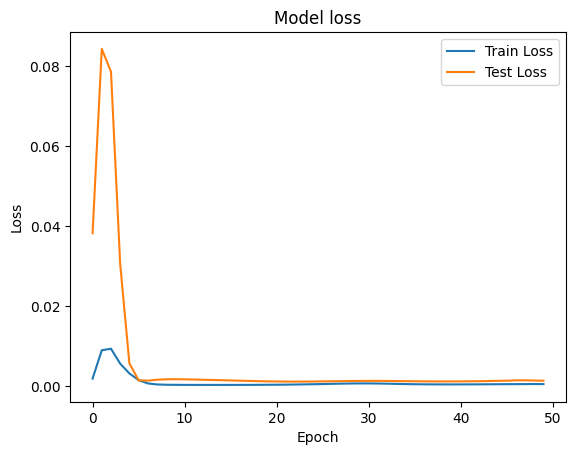

In [501]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

#### Model Prediction

In [502]:
test_predict = model.predict(X_test)

40/40 [==============================] - 1s 3ms/step


In [503]:
# Create dummy matrix with the same shape as original feature matrix
dummy_test = np.zeros((144, len(features)))

# Insert the predicted values into the first column (assuming consumption is the first feature)
dummy_test[:, 0] = pd.DataFrame(test_predict)[0][-144:].values #test_predict[-1]

# Inverse transform using the scaler
test_predict_inv = scaler.inverse_transform(dummy_test)[:, 0]


In [504]:
specified_date_dt = datetime.strptime(specified_date, '%Y-%m-%d %H:%M:%S')
result_date = specified_date_dt - timedelta(hours=120)
result_date_str = result_date.strftime('%Y-%m-%d %H:%M:%S')
dates = pd.date_range(start=result_date_str, periods=144, freq='H')
dates = dates.rename('Date')
test_predict_df = pd.DataFrame(index=dates)
test_predict_df['predicted'] = test_predict_inv
test_predict_df['consumption'] = actual_void_data_city['consumption'].values
test_predict_df

,predicted,consumption
Date,,
2022-12-27 00:00:00,11.433930,11.379460
2022-12-27 01:00:00,10.956200,11.159007
2022-12-27 02:00:00,10.613812,11.001117
2022-12-27 03:00:00,10.382564,10.858846
2022-12-27 04:00:00,10.191760,10.943406
...,...,...
2023-01-01 19:00:00,12.628988,15.685556
2023-01-01 20:00:00,12.449530,15.264776
2023-01-01 21:00:00,12.271406,14.799120


In [505]:
dates = pd.date_range(start=specified_date, periods=24, freq='H')
dates = dates.rename('Date')
actual_data_city['predicted'] = test_predict_inv[-24:]
actual_data_city.set_index('time', inplace=True)
actual_data_city

,location,consumption,temperature,predicted
time,,,,
2023-01-01 00:00:00,oslo,11.608362,-1.7,12.822768
2023-01-01 01:00:00,oslo,11.550801,-1.7,12.478451
2023-01-01 02:00:00,oslo,11.268630,-3.4,12.180573
2023-01-01 03:00:00,oslo,11.227266,-3.1,11.852776
2023-01-01 04:00:00,oslo,11.227632,-4.0,11.595583
2023-01-01 05:00:00,oslo,11.407358,-4.4,11.369391
2023-01-01 06:00:00,oslo,11.596563,-4.1,11.562812
2023-01-01 07:00:00,oslo,11.873966,-4.2,11.557638
2023-01-01 08:00:00,oslo,12.507845,-4.2,11.698458


#### Visualization of Prediction

In [506]:
train_data_city_last24 = train_data_city[-24:].copy()
train_data_city_last24.set_index('time', inplace=True)


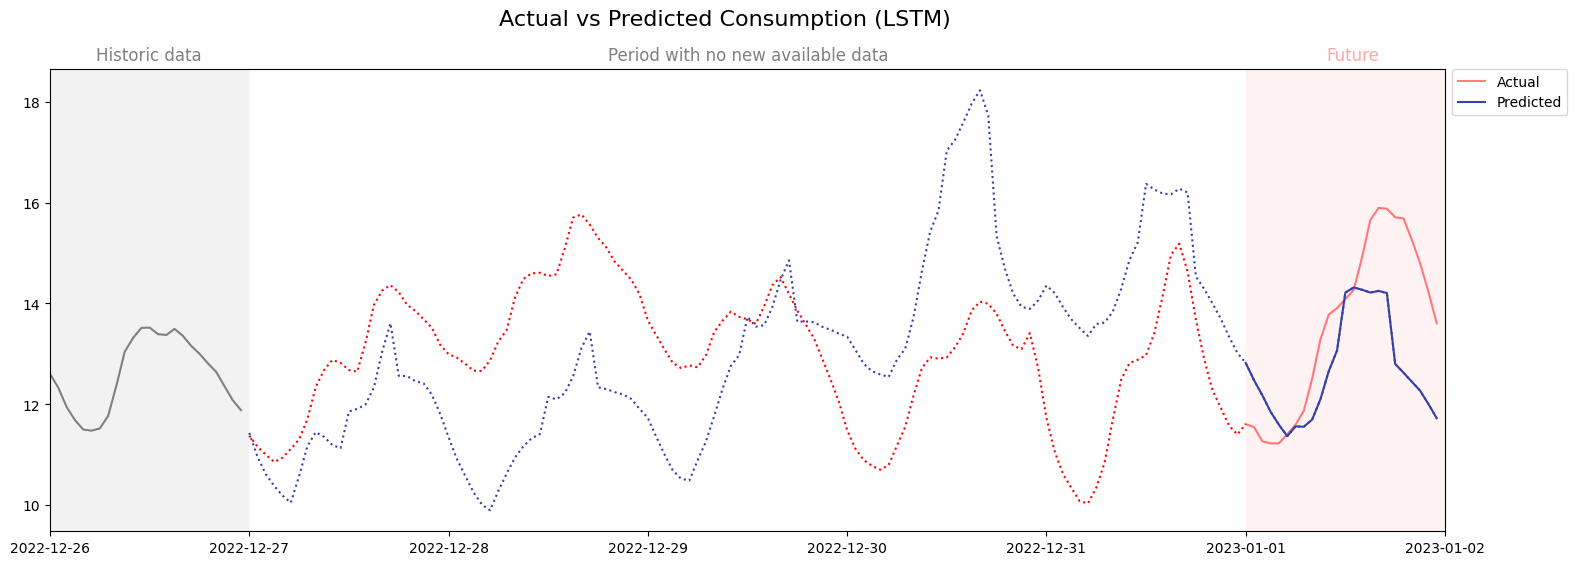

In [507]:
fig, axes = plt.subplots(1, 1, figsize=(18, 6))
axes.plot(actual_data_city['consumption'], label='Actual', color='red', alpha=0.5)
axes.plot(test_predict_df['predicted'], linestyle='dotted', color='#3242a8')#, label='120 hours prediction')
axes.plot(test_predict_df['consumption'][:-23], linestyle='dotted', color='red')
axes.axvspan(specified_date_dt, xmax=specified_date_dt+timedelta(hours=24), facecolor='red', alpha=0.05)
axes.axvspan(specified_date_dt-timedelta(hours=144), xmax=specified_date_dt-timedelta(hours=120), facecolor='black', alpha=0.05)
axes.plot(train_data_city_last24['consumption'], color='grey')#, label='Historic')
axes.plot(actual_data_city['predicted'], label='Predicted', color='#3242a8')
axes.text(0.033, 1.05, 'Historic data', transform=axes.transAxes, fontsize=12, verticalalignment='top', color='grey')
axes.text(0.4, 1.05, 'Period with no new available data', transform=axes.transAxes, fontsize=12, verticalalignment='top', color='grey')
axes.text(0.915, 1.05, 'Future', transform=axes.transAxes, fontsize=12, verticalalignment='top', color='red', alpha=0.35)
axes.set_xlim([specified_date_dt-timedelta(hours=144), specified_date_dt + timedelta(hours=24)])

plt.suptitle('Actual vs Predicted Consumption (LSTM)', fontsize=16)
plt.legend(bbox_to_anchor=(1.005, 1), loc='upper left', borderaxespad=0)
plt.show()


### Benchmark Prediction #1
The previous 144 hours are used as a prediction for the next. The hours each typically behaves similar therefore the prediction won't be too bad and serves as a okay benchmark.

In [508]:
train_data_city # The training data
actual_void_data_city # The void data that is not accessable, but needs to be predicted
actual_data_city # The actual data we want to predict

test_predict_df['benchmark_prediction_1'] = train_data_city[-144:]['consumption'].values
test_predict_df

,predicted,consumption,benchmark_prediction_1
Date,,,
2022-12-27 00:00:00,11.433930,11.379460,10.977095
2022-12-27 01:00:00,10.956200,11.159007,10.747878
2022-12-27 02:00:00,10.613812,11.001117,10.581901
2022-12-27 03:00:00,10.382564,10.858846,10.369991
2022-12-27 04:00:00,10.191760,10.943406,10.343914
...,...,...,...
2023-01-01 19:00:00,12.628988,15.685556,12.815122
2023-01-01 20:00:00,12.449530,15.264776,12.648255
2023-01-01 21:00:00,12.271406,14.799120,12.365443


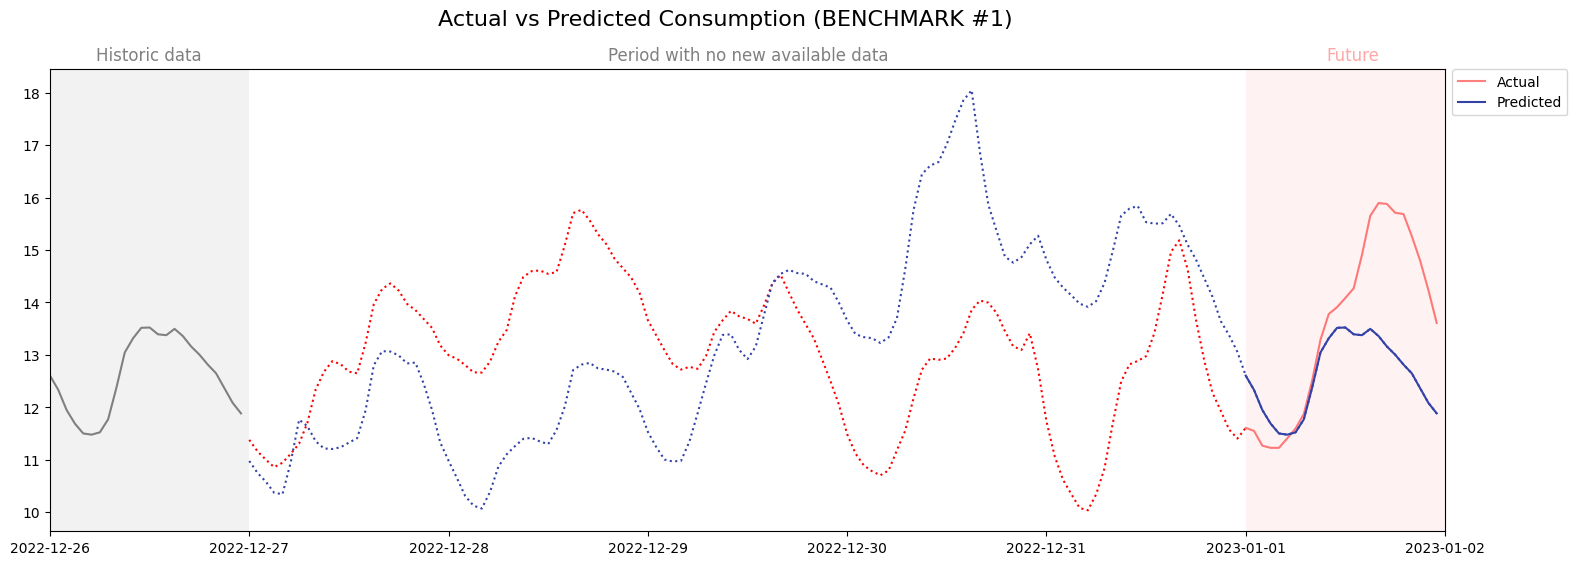

In [509]:
fig, axes = plt.subplots(1, 1, figsize=(18, 6))
axes.plot(actual_data_city['consumption'], label='Actual', color='red', alpha=0.5)
axes.plot(test_predict_df['consumption'][:-23], linestyle='dotted', color='red')
axes.plot(test_predict_df['benchmark_prediction_1'], linestyle='dotted', color='#3242a8')
axes.axvspan(specified_date_dt, xmax=specified_date_dt+timedelta(hours=24), facecolor='red', alpha=0.05)
axes.axvspan(specified_date_dt-timedelta(hours=144), xmax=specified_date_dt-timedelta(hours=120), facecolor='black', alpha=0.05)
axes.plot(train_data_city_last24['consumption'], color='grey')#, label='Historic')
axes.plot(test_predict_df['benchmark_prediction_1'][-24:], label='Predicted', color='#3242a8')
axes.text(0.033, 1.05, 'Historic data', transform=axes.transAxes, fontsize=12, verticalalignment='top', color='grey')
axes.text(0.4, 1.05, 'Period with no new available data', transform=axes.transAxes, fontsize=12, verticalalignment='top', color='grey')
axes.text(0.915, 1.05, 'Future', transform=axes.transAxes, fontsize=12, verticalalignment='top', color='red', alpha=0.35)
axes.set_xlim([specified_date_dt-timedelta(hours=144), specified_date_dt + timedelta(hours=24)])

plt.suptitle('Actual vs Predicted Consumption (BENCHMARK #1)', fontsize=16)
plt.legend(bbox_to_anchor=(1.005, 1), loc='upper left', borderaxespad=0)
plt.show()


In [510]:
train_data_city[features]

,consumption,temperature,consumption_lag_1,consumption_lag_2,consumption_lag_3,time_of_day_Morning,time_of_day_Afternoon,time_of_day_Evening,time_of_day_Night
0,3.584066,0.2,3.660981,3.818095,4.092830,False,False,False,True
1,3.549536,0.4,3.584066,3.660981,3.818095,False,False,False,True
2,3.552738,0.0,3.549536,3.584066,3.660981,False,False,False,True
3,3.638570,-0.4,3.552738,3.549536,3.584066,False,False,False,True
4,3.929940,-0.5,3.638570,3.552738,3.549536,False,False,False,True
...,...,...,...,...,...,...,...,...,...
6307,12.815122,1.9,13.003467,13.159993,13.358431,False,False,True,False
6308,12.648255,1.2,12.815122,13.003467,13.159993,False,False,True,False
6309,12.365443,0.3,12.648255,12.815122,13.003467,False,False,True,False
6310,12.084627,-1.7,12.365443,12.648255,12.815122,False,False,True,False


### Better(?) LSTM Prediction
By using the temperatures combined with the predicted void consumption, there may be better results for the 24 hours predicted.

In [511]:
data_city = data[data['location'] == location].copy()
data_city.sort_values('time', inplace=True)
data_city.reset_index(drop=True, inplace=True)
date_index = data_city[data_city['time'] == specified_date].index[0]
train_data_city = data_city.iloc[:date_index-120].copy()
actual_void_data_city = data_city.iloc[date_index-120:date_index+24].copy()

In [512]:
train_data_city

,time,location,consumption,temperature
0,2022-04-07 21:00:00,oslo,4.092830,1.0
1,2022-04-07 22:00:00,oslo,3.818095,0.4
2,2022-04-07 23:00:00,oslo,3.660981,0.3
3,2022-04-08 00:00:00,oslo,3.584066,0.2
4,2022-04-08 01:00:00,oslo,3.549536,0.4
...,...,...,...,...
6310,2022-12-26 19:00:00,oslo,12.815122,1.9
6311,2022-12-26 20:00:00,oslo,12.648255,1.2
6312,2022-12-26 21:00:00,oslo,12.365443,0.3
6313,2022-12-26 22:00:00,oslo,12.084627,-1.7


In [513]:
predicted_void_data_city = actual_void_data_city[:120].copy()
predicted_void_data_city['consumption'] = test_predict_df['predicted'][:120].values
predicted_void_data_city

,time,location,consumption,temperature
6315,2022-12-27 00:00:00,oslo,11.433930,-4.1
6316,2022-12-27 01:00:00,oslo,10.956200,-4.3
6317,2022-12-27 02:00:00,oslo,10.613812,-4.3
6318,2022-12-27 03:00:00,oslo,10.382564,-4.6
6319,2022-12-27 04:00:00,oslo,10.191760,-4.0
...,...,...,...,...
6430,2022-12-31 19:00:00,oslo,14.287453,-1.0
6431,2022-12-31 20:00:00,oslo,14.002626,-2.2
6432,2022-12-31 21:00:00,oslo,13.695750,-2.9
6433,2022-12-31 22:00:00,oslo,13.338544,-2.2


In [514]:
train_data_city_new = pd.concat([train_data_city,predicted_void_data_city])
train_data_city_new

,time,location,consumption,temperature
0,2022-04-07 21:00:00,oslo,4.092830,1.0
1,2022-04-07 22:00:00,oslo,3.818095,0.4
2,2022-04-07 23:00:00,oslo,3.660981,0.3
3,2022-04-08 00:00:00,oslo,3.584066,0.2
4,2022-04-08 01:00:00,oslo,3.549536,0.4
...,...,...,...,...
6430,2022-12-31 19:00:00,oslo,14.287453,-1.0
6431,2022-12-31 20:00:00,oslo,14.002626,-2.2
6432,2022-12-31 21:00:00,oslo,13.695750,-2.9
6433,2022-12-31 22:00:00,oslo,13.338544,-2.2


In [515]:
# Creating lagged features
n_lags = 3
for lag in range(1, n_lags + 1):
    train_data_city_new[f'consumption_lag_{lag}'] = train_data_city_new['consumption'].shift(lag)

# dropping NaN values after lagging and resetting index
train_data_city_new = train_data_city_new.dropna().reset_index(drop=True)

# Time of day feature
train_data_city_new['hour'] = train_data_city_new['time'].dt.hour
train_data_city_new['time_of_day'] = pd.cut(train_data_city_new['hour'], bins=[0, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'], right=False)
#one-hot encode the time_of_day feature
time_of_day_encoded = pd.get_dummies(train_data_city_new['time_of_day'], prefix='time_of_day')
train_data_city_new = pd.concat([train_data_city_new, time_of_day_encoded], axis=1)

# normalizing data
scaler = MinMaxScaler(feature_range=(0, 1))
data_city_scaled_new = scaler.fit_transform(train_data_city_new[features])

X = data_city_scaled_new[:, 1:]
y = data_city_scaled_new[:, 0]

test_size = 0.2  # using 20% of the data for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

#Reshaping [samples, time steps, features] as required for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

model = Sequential()
model.add(LSTM(256, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(24)) # A 24 hours prediction

model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=72,
    validation_data=(X_test, y_test),
    verbose=2,
    shuffle=False
)

Epoch 1/50
72/72 - 4s - loss: 0.0018 - val_loss: 0.0379 - 4s/epoch - 59ms/step
Epoch 2/50
72/72 - 1s - loss: 0.0081 - val_loss: 0.0634 - 719ms/epoch - 10ms/step
Epoch 3/50
72/72 - 1s - loss: 0.0096 - val_loss: 0.0650 - 718ms/epoch - 10ms/step
Epoch 4/50
72/72 - 1s - loss: 0.0053 - val_loss: 0.0176 - 936ms/epoch - 13ms/step
Epoch 5/50
72/72 - 1s - loss: 0.0027 - val_loss: 0.0026 - 934ms/epoch - 13ms/step
Epoch 6/50
72/72 - 1s - loss: 0.0012 - val_loss: 0.0013 - 880ms/epoch - 12ms/step
Epoch 7/50
72/72 - 1s - loss: 5.8034e-04 - val_loss: 0.0016 - 922ms/epoch - 13ms/step
Epoch 8/50
72/72 - 1s - loss: 4.1552e-04 - val_loss: 0.0018 - 925ms/epoch - 13ms/step
Epoch 9/50
72/72 - 1s - loss: 3.6463e-04 - val_loss: 0.0019 - 869ms/epoch - 12ms/step
Epoch 10/50
72/72 - 1s - loss: 3.4562e-04 - val_loss: 0.0019 - 868ms/epoch - 12ms/step
Epoch 11/50
72/72 - 1s - loss: 3.3702e-04 - val_loss: 0.0018 - 735ms/epoch - 10ms/step
Epoch 12/50
72/72 - 1s - loss: 3.3264e-04 - val_loss: 0.0018 - 732ms/epoch - 10

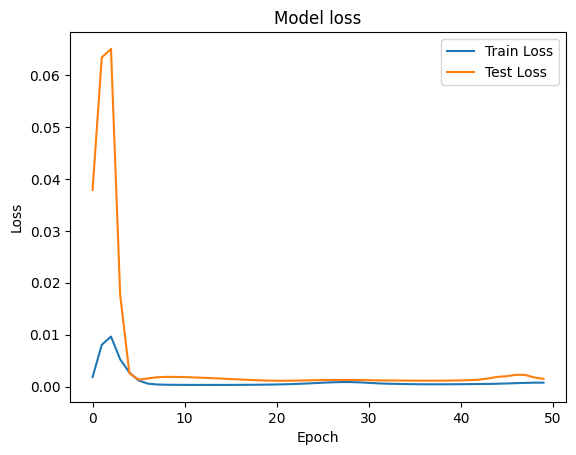

In [516]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [517]:
test_predict = model.predict(X_test)

# Create dummy matrix with the same shape as original feature matrix
dummy_test = np.zeros((24, len(features)))

# Insert the predicted values into the first column (assuming consumption is the first feature)
dummy_test[:, 0] = pd.DataFrame(test_predict)[0][-24:].values #test_predict[-1]

# Inverse transform using the scaler
test_predict_inv = scaler.inverse_transform(dummy_test)[:, 0]

specified_date_dt = datetime.strptime(specified_date, '%Y-%m-%d %H:%M:%S')
result_date = specified_date_dt
result_date_str = result_date.strftime('%Y-%m-%d %H:%M:%S')
dates = pd.date_range(start=result_date_str, periods=24, freq='H')
dates = dates.rename('Date')
test_predict_new_df = pd.DataFrame(index=dates)
test_predict_new_df['predicted'] = test_predict_inv
test_predict_df['predicted_better'] = list(predicted_void_data_city['consumption'].values) + list(test_predict_new_df['predicted'].values)


41/41 [==============================] - 1s 3ms/step


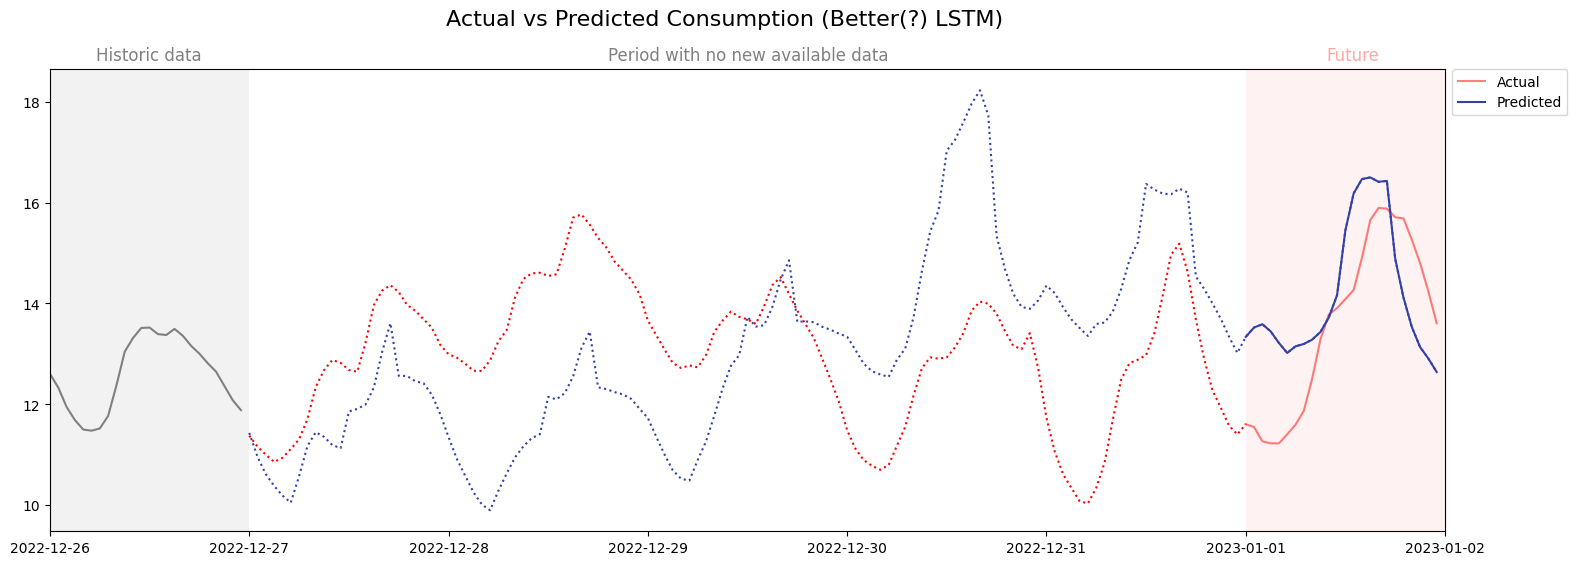

In [518]:
fig, axes = plt.subplots(1, 1, figsize=(18, 6))
axes.plot(actual_data_city['consumption'], label='Actual', color='red', alpha=0.5)
#axes.plot(test_predict_df['predicted'], linestyle='dotted', color='grey')#, label='120 hours prediction')
axes.plot(test_predict_df['predicted_better'], linestyle='dotted', color='#3242a8')
axes.plot(test_predict_df['consumption'][:-23], linestyle='dotted', color='red')
axes.axvspan(specified_date_dt, xmax=specified_date_dt+timedelta(hours=24), facecolor='red', alpha=0.05)
axes.axvspan(specified_date_dt-timedelta(hours=144), xmax=specified_date_dt-timedelta(hours=120), facecolor='black', alpha=0.05)
axes.plot(train_data_city_last24['consumption'], color='grey')#, label='Historic')
#axes.plot(actual_data_city['consumption'], label='Predicted', color='grey')
axes.plot(test_predict_df['predicted_better'][-24:], label='Predicted', color='#3242a8')
axes.text(0.033, 1.05, 'Historic data', transform=axes.transAxes, fontsize=12, verticalalignment='top', color='grey')
axes.text(0.4, 1.05, 'Period with no new available data', transform=axes.transAxes, fontsize=12, verticalalignment='top', color='grey')
axes.text(0.915, 1.05, 'Future', transform=axes.transAxes, fontsize=12, verticalalignment='top', color='red', alpha=0.35)
axes.set_xlim([specified_date_dt-timedelta(hours=144), specified_date_dt + timedelta(hours=24)])

plt.suptitle('Actual vs Predicted Consumption (Better(?) LSTM)', fontsize=16)
plt.legend(bbox_to_anchor=(1.005, 1), loc='upper left', borderaxespad=0)
plt.show()


### Evaluation Metrics

In [519]:
final_predictions = test_predict_df[-24:]
final_predictions

,predicted,consumption,benchmark_prediction_1,predicted_better
Date,,,,
2023-01-01 00:00:00,12.822768,11.608362,12.604906,13.337294
2023-01-01 01:00:00,12.478451,11.550801,12.331463,13.522790
2023-01-01 02:00:00,12.180573,11.268630,11.948743,13.589063
2023-01-01 03:00:00,11.852776,11.227266,11.689323,13.447627
2023-01-01 04:00:00,11.595583,11.227632,11.501761,13.217176
2023-01-01 05:00:00,11.369391,11.407358,11.478627,13.019142
2023-01-01 06:00:00,11.562812,11.596563,11.522422,13.151275
2023-01-01 07:00:00,11.557638,11.873966,11.770909,13.197511
2023-01-01 08:00:00,11.698458,12.507845,12.374634,13.282753


In [521]:
y_true = final_predictions['consumption']
y_pred_benchmark = final_predictions['benchmark_prediction_1']
y_pred_better = final_predictions['predicted_better']
y_pred = final_predictions['predicted']

mae_better = mean_absolute_error(y_true, y_pred_better)
mse_better = mean_squared_error(y_true, y_pred_better)
rmse_better = mean_squared_error(y_true, y_pred_better, squared=False)  # if squared=False, this is RMSE
r2_better = r2_score(y_true, y_pred_better)

mae_benchmark = mean_absolute_error(y_true, y_pred_benchmark)
mse_benchmark = mean_squared_error(y_true, y_pred_benchmark)
rmse_benchmark = mean_squared_error(y_true, y_pred_benchmark, squared=False)
r2_benchmark = r2_score(y_true, y_pred_benchmark)

mae_pred = mean_absolute_error(y_true, y_pred)
mse_pred = mean_squared_error(y_true, y_pred)
rmse_pred = mean_squared_error(y_true, y_pred, squared=False)
r2_pred = r2_score(y_true, y_pred)

print("\nMetrics for Benchmark #1:")
print(f"MAE: {mae_benchmark}")
print(f"MSE: {mse_benchmark}")
print(f"RMSE: {rmse_benchmark}")
print(f"R-squared: {r2_benchmark}")

print("\nMetrics for LSTM:")
print(f"MAE: {mae_pred}")
print(f"MSE: {mse_pred}")
print(f"RMSE: {rmse_pred}")
print(f"R-squared: {r2_pred}")

print("\nMetrics for Better(?) LSTM:")
print(f"MAE: {mae_better}")
print(f"MSE: {mse_better}")
print(f"RMSE: {rmse_better}")
print(f"R-squared: {r2_better}")



Metrics for Benchmark #1:
MAE: 1.2314584583333337
MSE: 2.5267084437570415
RMSE: 1.5895623434634583
R-squared: 0.11450908291977213

Metrics for LSTM:
MAE: 1.2237695812263218
MSE: 2.350564005406488
RMSE: 1.5331549189193139
R-squared: 0.17623931564171225

Metrics for Better(?) LSTM:
MAE: 1.2826668228478257
MSE: 2.059639993727473
RMSE: 1.4351445898331892
R-squared: 0.2781943198048601


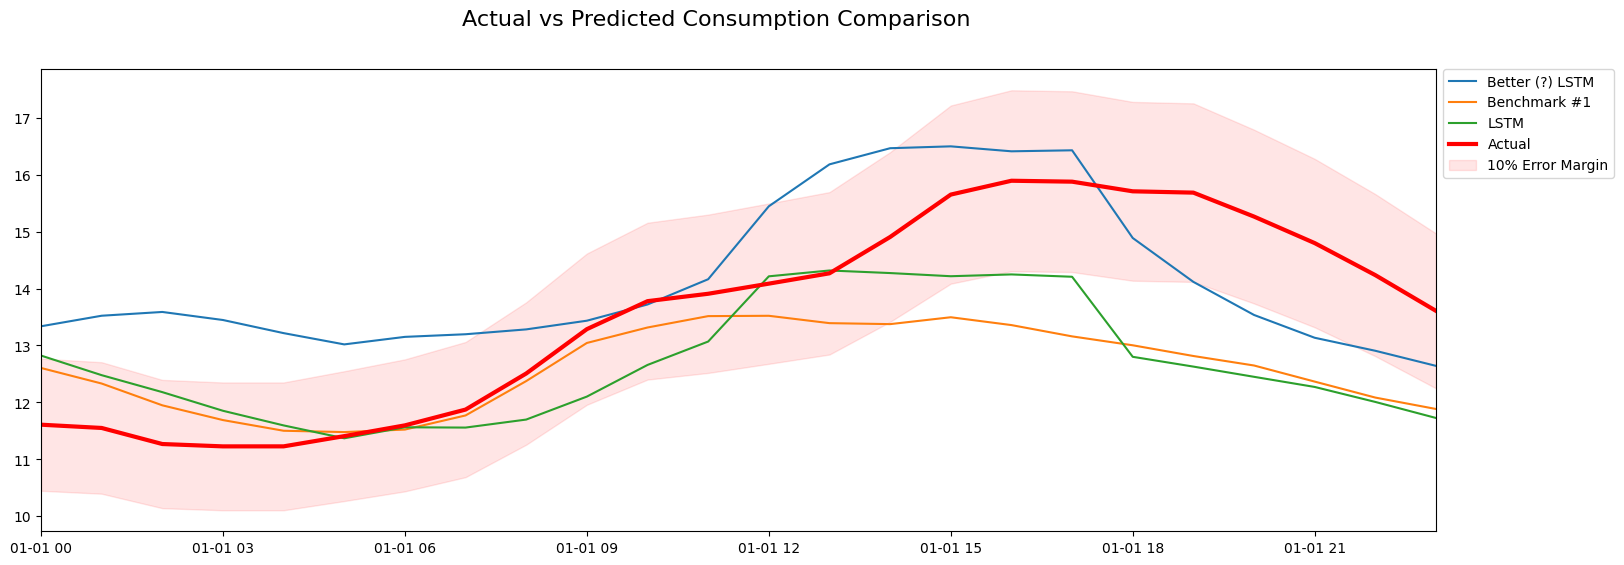

In [545]:
fig, axes = plt.subplots(1, 1, figsize=(18, 6))

axes.plot(test_predict_df['predicted_better'][-24:], label='Better (?) LSTM')
axes.plot(test_predict_df['benchmark_prediction_1'][-24:], label='Benchmark #1')
axes.plot(actual_data_city['predicted'][-24:], label='LSTM')

axes.plot(actual_data_city['consumption'][-24:], label='Actual', color='red', linewidth=3)

upper_bound = actual_data_city['consumption'] * 1.10
lower_bound = actual_data_city['consumption'] * 0.90

axes.fill_between(actual_data_city.index[-24:], lower_bound[-24:], upper_bound[-24:], color='red', alpha=0.1, label='10% Error Margin')

axes.set_xlim([specified_date_dt, specified_date_dt + timedelta(hours=23)])

plt.suptitle('Actual vs Predicted Consumption Comparison', fontsize=16)
plt.legend(bbox_to_anchor=(1.005, 1), loc='upper left', borderaxespad=0)
plt.show()